In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Readme
Change dataset, crop_id, obj_id only

# 1. Crop images

In [44]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model) #, crop_overlap_ratio = 750 / 1500) # , box_nms_thresh = 0.6 )

In [45]:
def move_to_device(segmentor_model, device="cuda"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

In [46]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections

dataset = "icbin"
rgb_path = "cnos_analysis/crop_proposals/000001.png" # f"datasets/bop23_challenge/datasets/{dataset}/test/000048/rgb/000001.png"
rgb = Image.open(rgb_path).convert("RGB")
detections = custom_sam_model.generate_masks(np.array(rgb))

In [47]:
np.expand_dims(np.array(rgb), 0).shape

(1, 480, 640, 3)

In [48]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

In [49]:
# # Visualize proposals
# import matplotlib.pyplot as plt
# from math import ceil
# def plot_images(images, rows, cols):
#     fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
#     for i, ax in enumerate(axes.flat):
#         if i >= len(images):
#             break
#         ax.imshow(images[i])
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Define the number of rows and columns in the grid
# rows = ceil(len(masked_images) / 6)
# cols = 6
# # Plot the masked_images array in a grid
# plot_images(masked_images, rows, cols) 

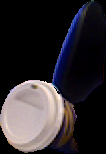

In [50]:
import os

# Choose crop 4 it is in object id 12
crop_idx = 131 # 125, 102 for background; 131 for foreground
obj_id = 1
crop1 = {
    "crop" : masked_images[crop_idx], # it is saved as Image so crop1["crop"] to visualize it
    "masks" : detections["masks"][crop_idx],
    "boxes" : detections["boxes"][crop_idx]
}

# Save image
if not os.path.exists(f"foundpose_analysis/{dataset}"):
    os.makedirs(f"foundpose_analysis/{dataset}")
crop1["crop"].save(f"foundpose_analysis/{dataset}/crop1.png")
crop1["crop"]

# 2. Templates

## 2.1 Create templates of object

In [52]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
# initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)

In [53]:
import os
import glob

default_ref_dataloader_config = cfg.data.reference_dataloader
ref_dataloader_config = default_ref_dataloader_config.copy()
ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = f"datasets/bop23_challenge/datasets/{dataset}"
ref_dataloader_config.template_dir = " "

level_template = 1 # Level 0 :42 templates, level 1, 162 templates
ref_dataloader_config.level_templates = level_template 
ref_dataloader_config.split = "train_pbr" # train_pbr

ply_files = glob.glob(f"datasets/bop23_challenge/datasets/{dataset}/models/models/*.ply")
obj_ids = sorted([int(os.path.basename(obj_id)[8:10]) for obj_id in ply_files])
ref_dataloader_config.obj_ids = obj_ids

out_folder = f"foundpose_analysis/{dataset}/templates"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
ref_dataloader_config.out_dir = out_folder
ref_dataloader_config.templates_output_folder = f"{out_folder}/level_template_{level_template}"

In [54]:
import os
os.environ['HYDRA_FULL_ERROR'] = '1'

In [55]:
# # Error : must delete all metadata.csv 
# # If using test it can happen that the object id doesnt appear in the test folder- so can get empty list - just use try except la ok
# from hydra.utils import instantiate
# ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
# ref_dataset.load_processed_metaData(reset_metaData=True)

In [56]:
# from torchvision.utils import save_image
# import pandas as pd

# templates = pd.read_csv(f"{out_folder}/{ref_dataloader_config.split}_processed_metaData.csv")

# # Save templates as images
# for ob_id in range(len(obj_ids)): 
#     obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}') # The transformed templates - check line 244, 245 in bop_pbr.py
#     original_obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}_original')
    
#     if not os.path.exists(obj_id_path):
#         os.makedirs(obj_id_path)
#     if not os.path.exists(original_obj_id_path):
#         os.makedirs(original_obj_id_path)

#     try:  
#         for i, img in enumerate(ref_dataset[ob_id]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))
#         for i, img in enumerate(ref_dataset[ob_id]["original_templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(original_obj_id_path, f'{i:06d}.png'))
#     except Exception as e:
#         print(f"An error occurred: {e}")

## 2.2. Templates features extraction

In [57]:
import glob
import os

obj_id_2 = 2
real_data_type = "test" # test

# Load original templates when before putting through dinov2 we also apply transfomation.
real_template_path_1 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id:06d}_original" 
real_template_path_2 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
real_template_files_1 = sorted(glob.glob(os.path.join(real_template_path_1, "*.png")), key=os.path.getmtime)
real_template_files_2 = sorted(glob.glob(os.path.join(real_template_path_2, "*.png")), key=os.path.getmtime)
real_template_files = real_template_files_1 + real_template_files_2
real_num_templates = len(real_template_files)
real_num_templates

324

In [58]:
import glob
import os

obj_id_2 = 2
syn_data_type = "train_pbr" # test

# Load original templates when before putting through dinov2 we also apply transformation.
syn_template_path_1 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id:06d}_original" 
syn_template_path_2 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
syn_template_files_1 = sorted(glob.glob(os.path.join(syn_template_path_1, "*.png")), key=os.path.getmtime)
syn_template_files_2 = sorted(glob.glob(os.path.join(syn_template_path_2, "*.png")), key=os.path.getmtime)
syn_template_files = syn_template_files_1 + syn_template_files_2
syn_num_templates = len(syn_template_files)
syn_num_templates

324

In [59]:
import glob
import os

obj_id_2 = 2

# Load original templates when before putting through dinov2 we also apply transformation.
pyrender_template_path_1 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id:06d}" 
pyrender_template_path_2 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id_2:06d}" 
pyrender_template_files_1 = sorted(glob.glob(os.path.join(pyrender_template_path_1, "*.png")), key=os.path.getmtime)
pyrender_template_files_2 = sorted(glob.glob(os.path.join(pyrender_template_path_2, "*.png")), key=os.path.getmtime)
pyrender_template_files = pyrender_template_files_1 + pyrender_template_files_2
pyrender_num_templates = len(pyrender_template_files)
pyrender_num_templates

1284

In [60]:
from PIL import Image
import numpy as np
# [50:450, 150:500, :3] only for pyrender template not for BlenderProc templates
real_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in real_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
syn_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in syn_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
pyrender_templates = [np.array(Image.open(template_file).convert("RGB"))[50:450, 150:500, :3] for template_file in pyrender_template_files]

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


normalized_templates shape torch.Size([3, 224, 224])
scaled_padded_templates.shape 324 torch.Size([3, 420, 420])


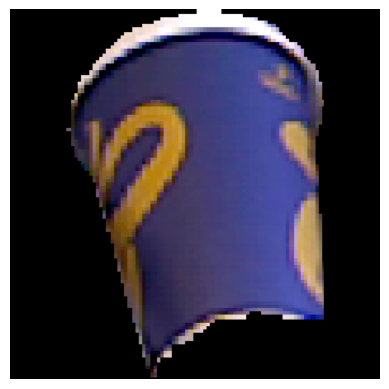

normalized_templates shape torch.Size([3, 224, 224])
scaled_padded_templates.shape 324 torch.Size([3, 420, 420])


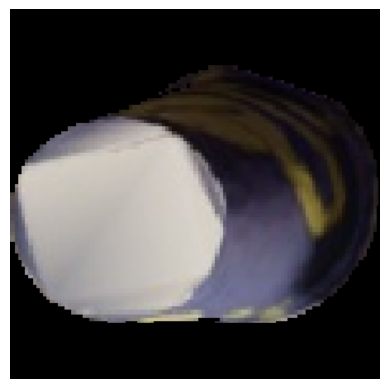

normalized_templates shape torch.Size([3, 400, 350])
scaled_padded_templates.shape 1284 torch.Size([3, 420, 420])


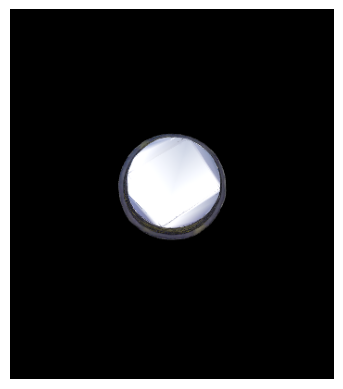

In [62]:
from src.model.custom_cnos import cnos_templates_feature_extraction

real_ref_features = cnos_templates_feature_extraction(
    templates = real_templates, num_templates = real_num_templates, dino_model = dinov2_vitl14, device = device
    )
syn_ref_features = cnos_templates_feature_extraction(
    templates = syn_templates, num_templates = syn_num_templates, dino_model = dinov2_vitl14, device = device
    )
pyrender_ref_features = cnos_templates_feature_extraction(
    templates = pyrender_templates, num_templates = pyrender_num_templates, dino_model = dinov2_vitl14, device = device
    )

In [63]:
pyrender_ref_features.shape

torch.Size([1284, 2700])

# 3. Extract features from crop and compare with templates

## 3.1 Normal crop

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


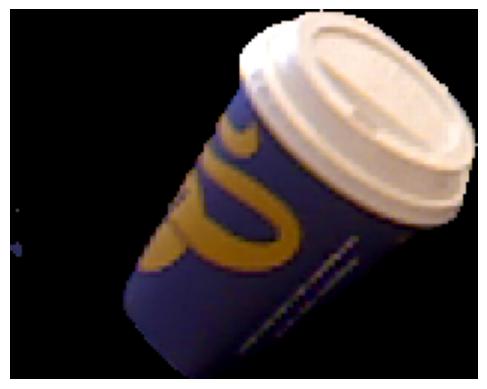

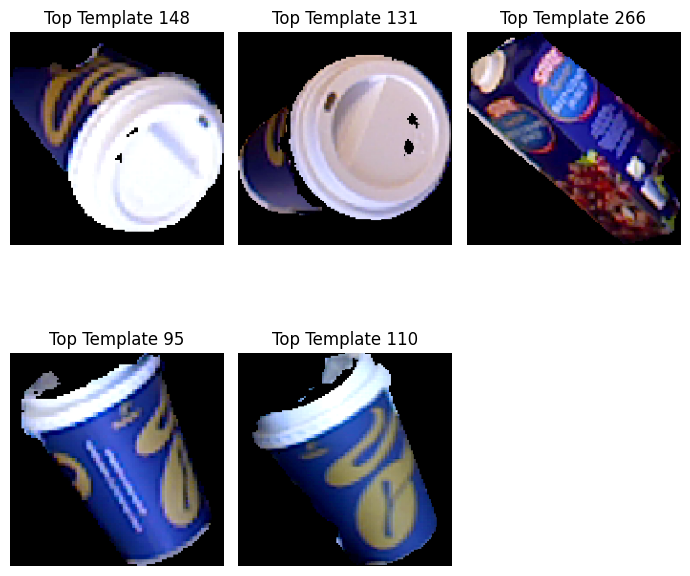

Top 5 scores: [0.786, 0.755, 0.742, 0.714, 0.702]
Average score: 0.74


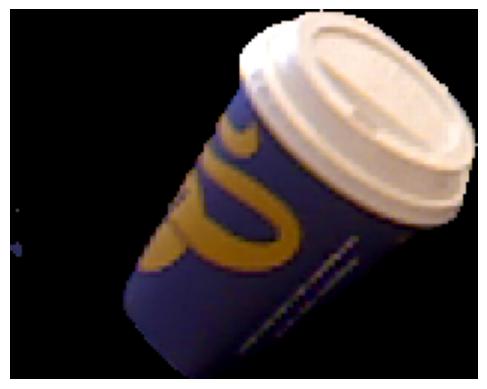

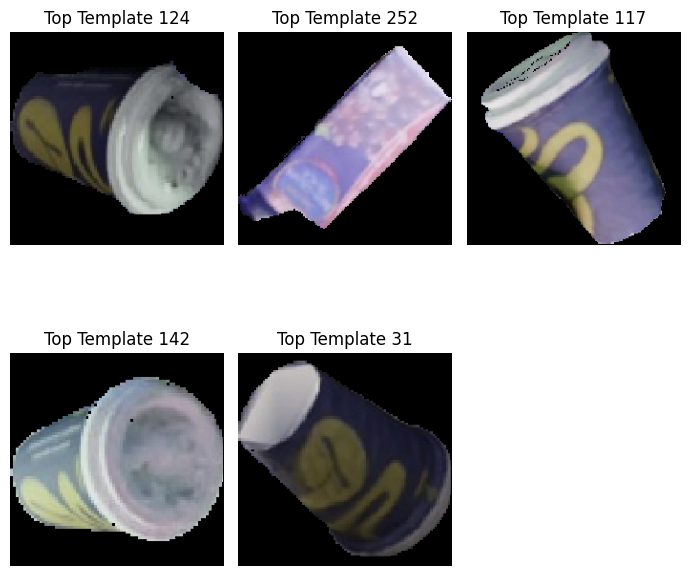

Top 5 scores: [0.846, 0.735, 0.715, 0.711, 0.706]
Average score: 0.742


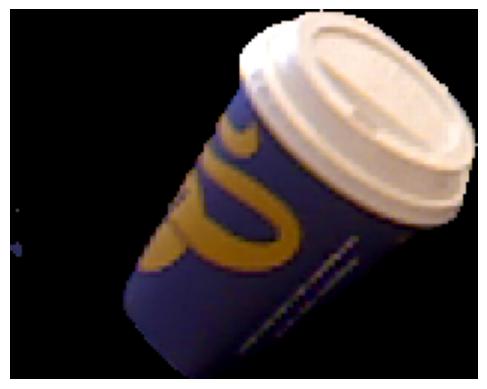

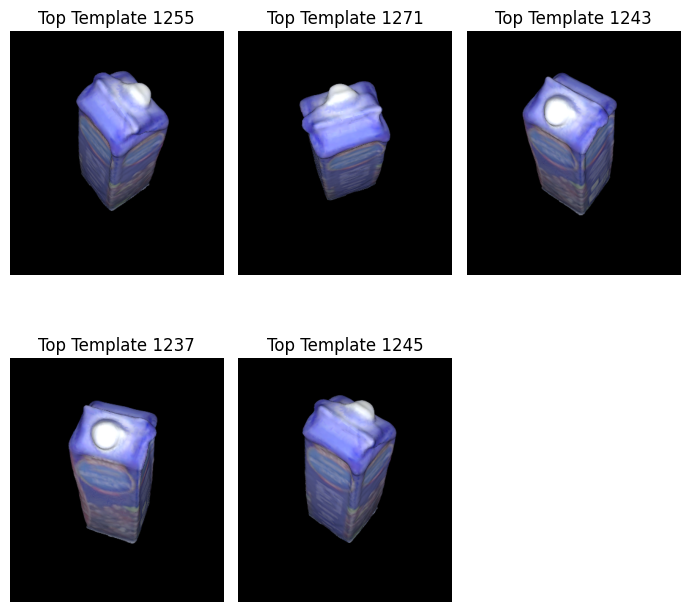

Top 5 scores: [0.617, 0.578, 0.574, 0.573, 0.564]
Average score: 0.581


In [64]:
from src.model.custom_cnos import cnos_crop_feature_extraction, calculate_similarity

# normal crop
crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB")) # (124, 157, 3)
normal_features = cnos_crop_feature_extraction(crop_rgb, dinov2_vitl14, device)
calculate_similarity(crop_rgb, normal_features, real_ref_features, real_templates)
calculate_similarity(crop_rgb, normal_features, syn_ref_features, syn_templates)
calculate_similarity(crop_rgb, normal_features, pyrender_ref_features, pyrender_templates)

## 3.2 Zoomed crop

In [65]:
from scipy.ndimage import zoom
def zoom_in(image, scale):
    return zoom(image, (scale, scale, 1))[image.shape[0]:,image.shape[1]:,:]

def zoom_out(image, scale):
    zoomed_out_image =  zoom(image, (1/scale, 1/scale, 1))
    # print(np.min(zoomed_out_image))
    background = np.zeros((image.shape[0], image.shape[1], image.shape[2]))
    background[image.shape[0]//2:zoomed_out_image.shape[0]+image.shape[0]//2, image.shape[0]//2:zoomed_out_image.shape[1]
        +image.shape[0]//2,:] = zoomed_out_image
    # print(np.min(background))
    # Clip values to be in the valid range [0, 255] and convert back to uint8
    background = background.astype("uint8")
    return background

crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB")) # (124, 157, 3)
zoom_scale = 3  # Zoom in by a factor of 2
crop_rgb_zoomed_in = zoom_in(crop_rgb, zoom_scale)
crop_rgb_zoomed_out = zoom_out(crop_rgb, scale=2)

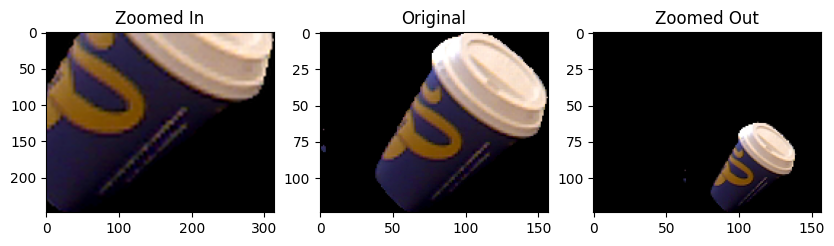

In [66]:
import matplotlib.pyplot as plt
# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title(f"Zoomed In")
plt.imshow(crop_rgb_zoomed_in)

plt.subplot(1, 3, 2)
plt.title(f"Original")
plt.imshow(crop_rgb)

plt.subplot(1, 3, 3)
plt.title(f"Zoomed Out")
plt.imshow(crop_rgb_zoomed_out)

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


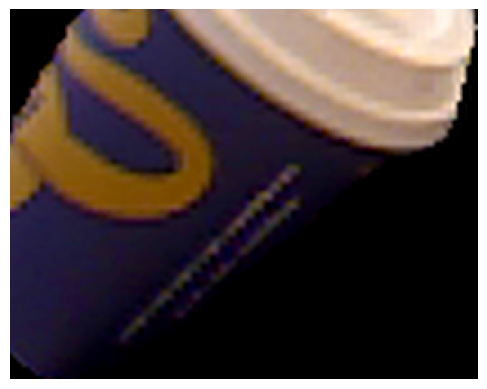

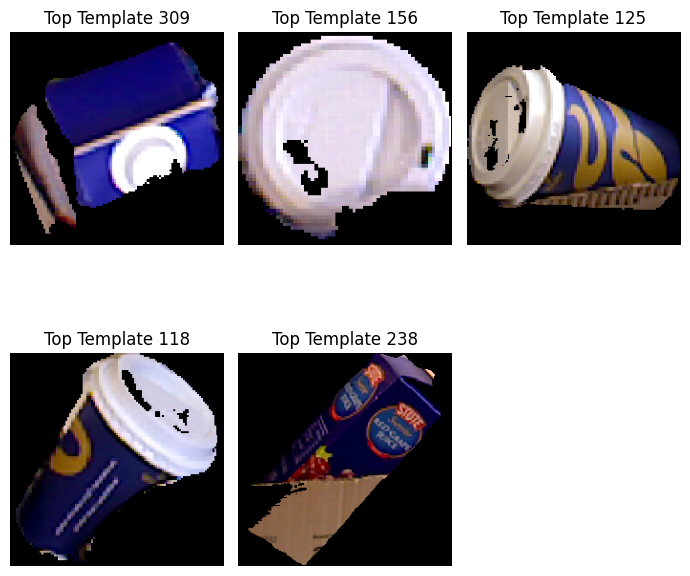

Top 5 scores: [0.783, 0.76, 0.715, 0.702, 0.688]
Average score: 0.73


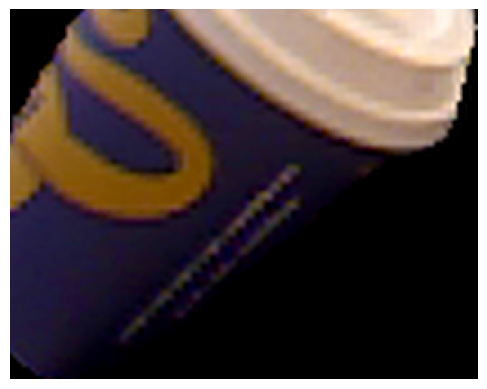

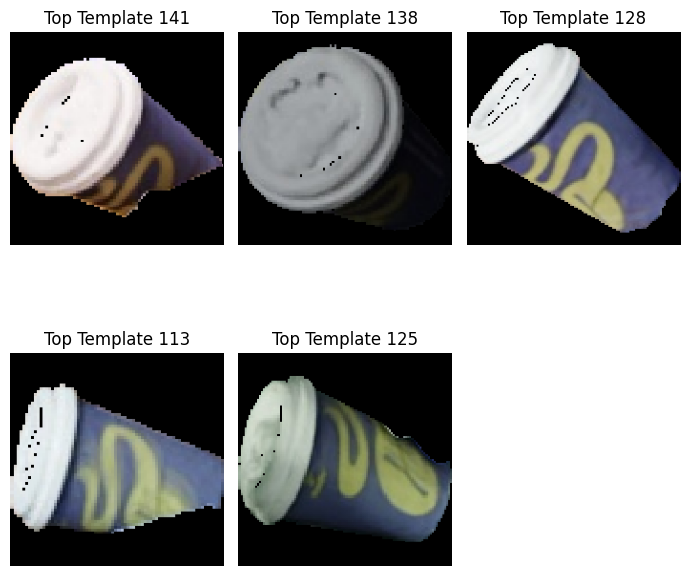

Top 5 scores: [0.77, 0.698, 0.672, 0.659, 0.652]
Average score: 0.69


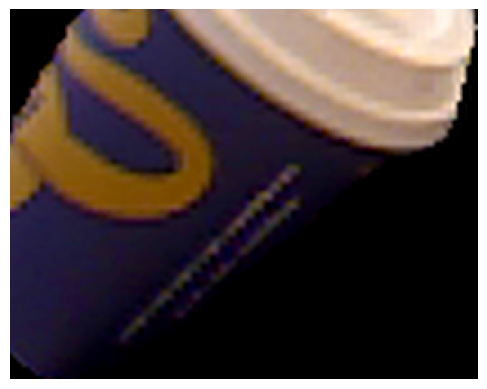

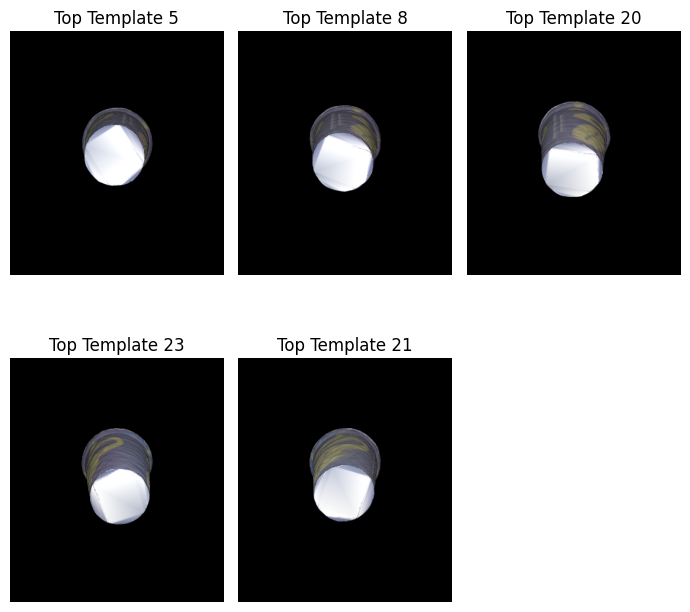

Top 5 scores: [0.642, 0.636, 0.634, 0.634, 0.634]
Average score: 0.636
Cosine similarity to the original crop tensor([[0.]])


In [67]:
from src.model.loss import PairwiseSimilarity, Similarity

metric = Similarity()
# Zoomed-in crop
zoom_in_features = cnos_crop_feature_extraction(crop_rgb_zoomed_in, dinov2_vitl14, device)
calculate_similarity(crop_rgb_zoomed_in, zoom_in_features, real_ref_features, real_templates)
calculate_similarity(crop_rgb_zoomed_in, zoom_in_features, syn_ref_features, syn_templates)
calculate_similarity(crop_rgb_zoomed_in, zoom_in_features, pyrender_ref_features, pyrender_templates)

# Calculate similarity between 2 features of nomrmal crop and rotated_45_crop
zoom_in_scores = metric(normal_features[:, None, :], zoom_in_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
print("Cosine similarity to the original crop", zoom_in_scores)

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


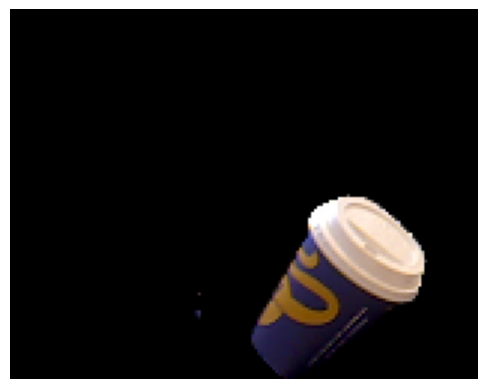

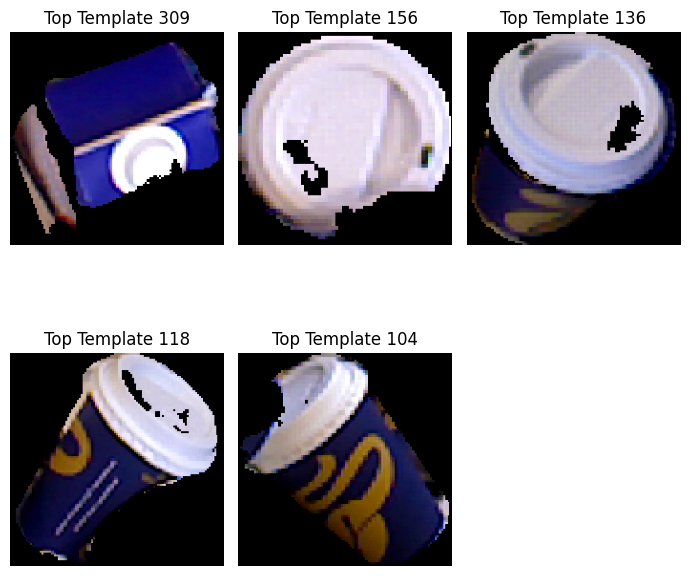

Top 5 scores: [0.853, 0.831, 0.755, 0.736, 0.593]
Average score: 0.754


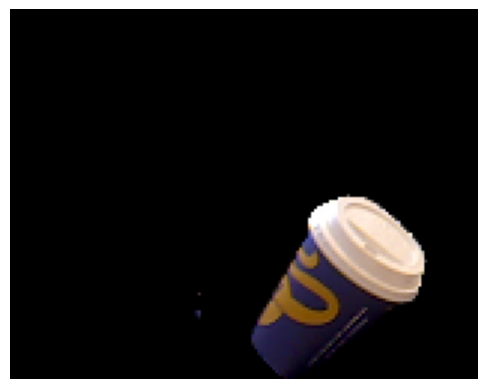

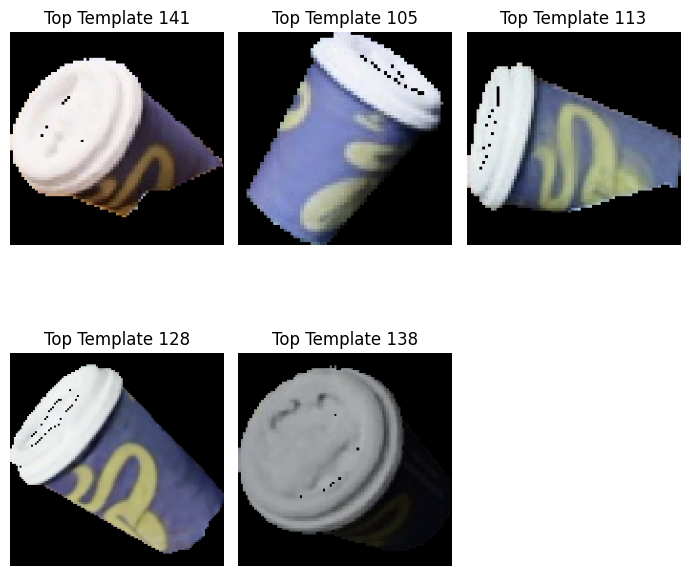

Top 5 scores: [0.64, 0.519, 0.515, 0.511, 0.509]
Average score: 0.539


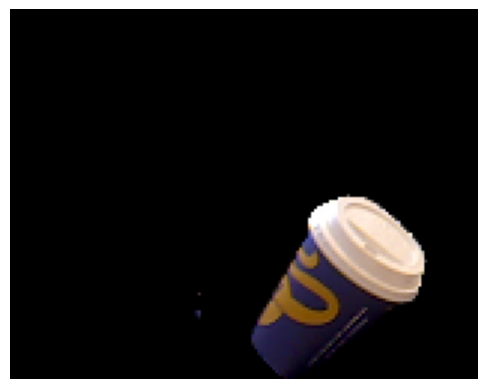

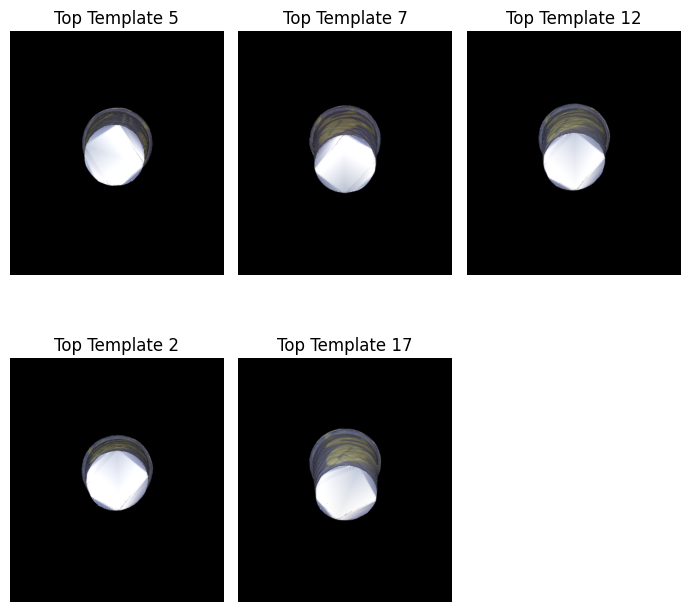

Top 5 scores: [0.644, 0.629, 0.627, 0.625, 0.623]
Average score: 0.63
Cosine similarity to the original crop tensor([[0.]])


In [68]:
# Zoomed-out crop
zoom_out_features = cnos_crop_feature_extraction(crop_rgb_zoomed_out, dinov2_vitl14, device)
calculate_similarity(crop_rgb_zoomed_out, zoom_out_features, real_ref_features, real_templates)
calculate_similarity(crop_rgb_zoomed_out, zoom_out_features, syn_ref_features, syn_templates)
calculate_similarity(crop_rgb_zoomed_out, zoom_out_features, pyrender_ref_features, pyrender_templates)
# Calculate similarity between 2 features of normal crop and rotated_45_crop
zoom_out_scores = metric(normal_features[:, None, :], zoom_out_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_proposals*num_templates instead
print("Cosine similarity to the original crop", zoom_out_scores)

## 3.3 In-plane rotated crop

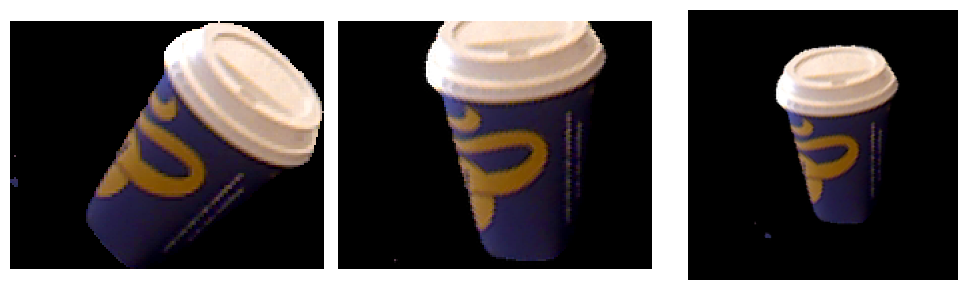

In [69]:
from scipy import ndimage, datasets
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 3))
ax1, ax2, ax3 = fig.subplots(1, 3)
img = crop_rgb
img_45 = ndimage.rotate(img, 45, reshape=False)
full_img_45 = ndimage.rotate(img, 45, reshape=True)
ax1.imshow(img, cmap='gray')
ax1.set_axis_off()
ax2.imshow(img_45, cmap='gray')
ax2.set_axis_off()
ax3.imshow(full_img_45, cmap='gray')
ax3.set_axis_off()
fig.set_layout_engine('tight')
plt.show()

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


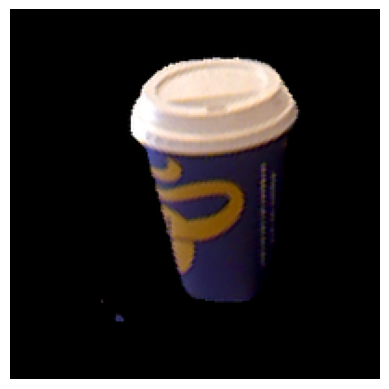

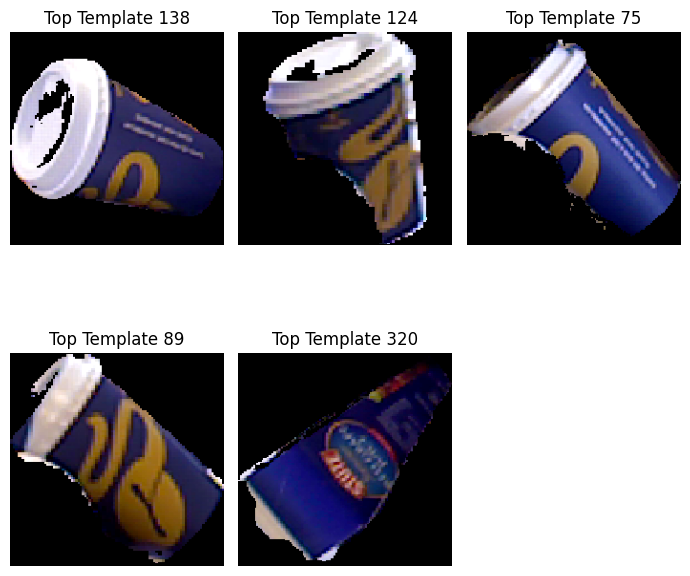

Top 5 scores: [0.481, 0.432, 0.35, 0.321, 0.284]
Average score: 0.374


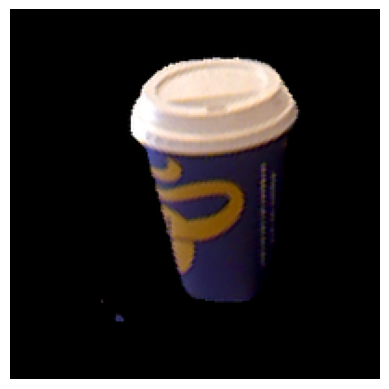

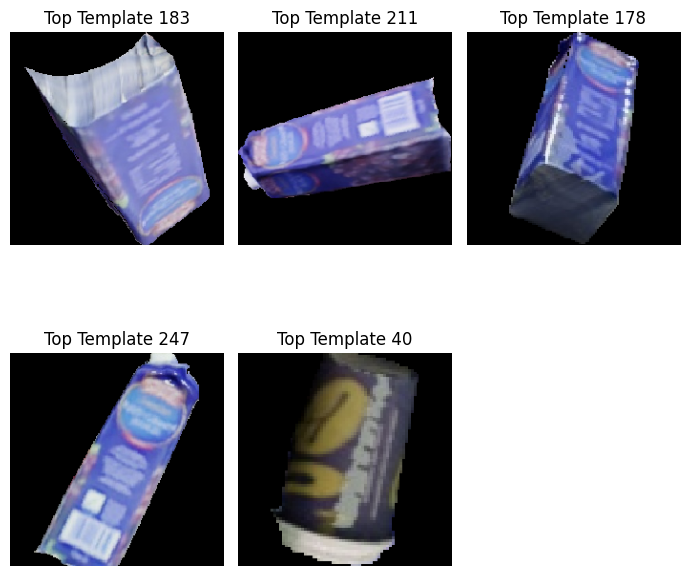

Top 5 scores: [0.439, 0.375, 0.359, 0.344, 0.33]
Average score: 0.37


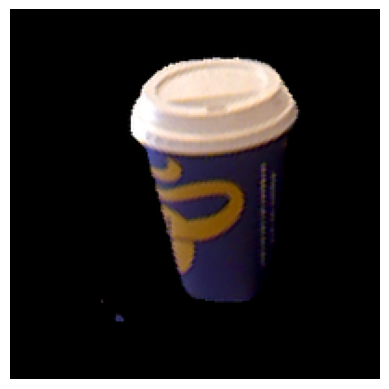

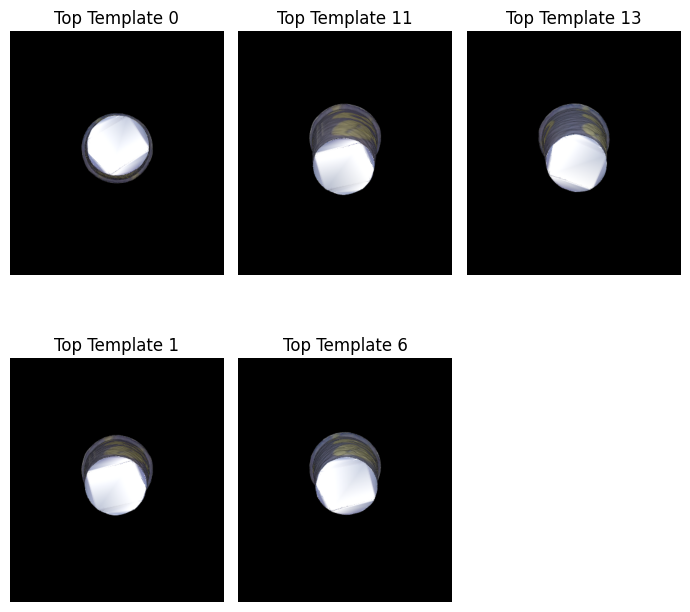

Top 5 scores: [0.511, 0.502, 0.496, 0.495, 0.49]
Average score: 0.499


tensor([[0.0166]])

In [70]:
# Rotate 45 
rotated_45_features = cnos_crop_feature_extraction(img_45, dinov2_vitl14, device)
calculate_similarity(full_img_45, rotated_45_features, real_ref_features, real_templates)
calculate_similarity(full_img_45, rotated_45_features, syn_ref_features, syn_templates)
calculate_similarity(full_img_45, rotated_45_features, pyrender_ref_features, pyrender_templates)
# Calculate similarity between 2 features of nomrmal crop and rotated_45_crop
rotated_45_scores = metric(normal_features[:, None, :], rotated_45_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
rotated_45_scores

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


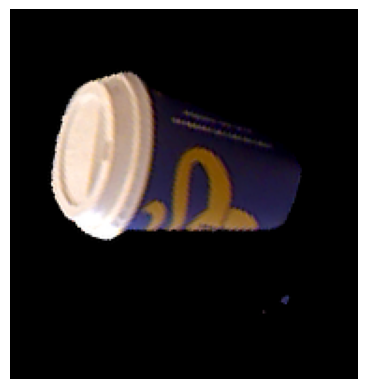

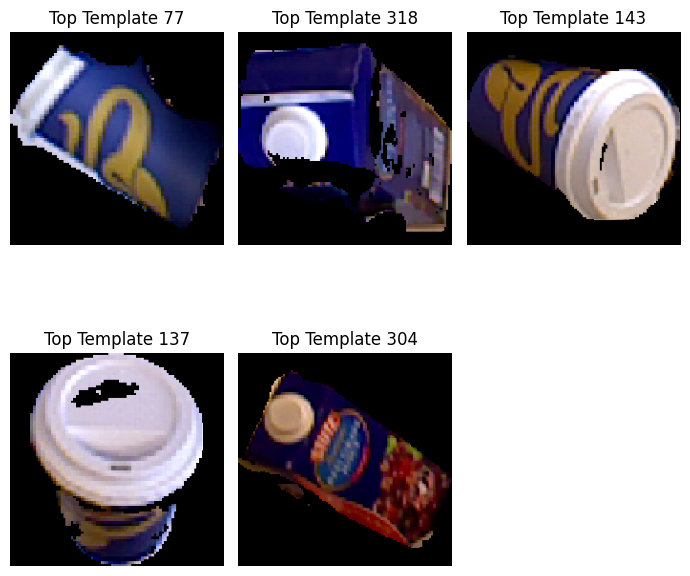

Top 5 scores: [0.837, 0.82, 0.733, 0.698, 0.682]
Average score: 0.754


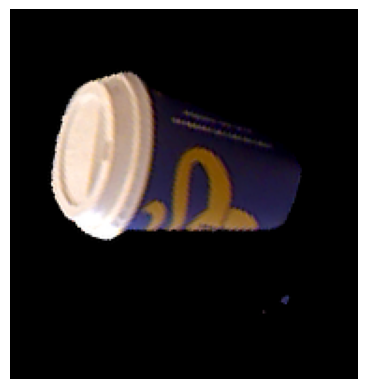

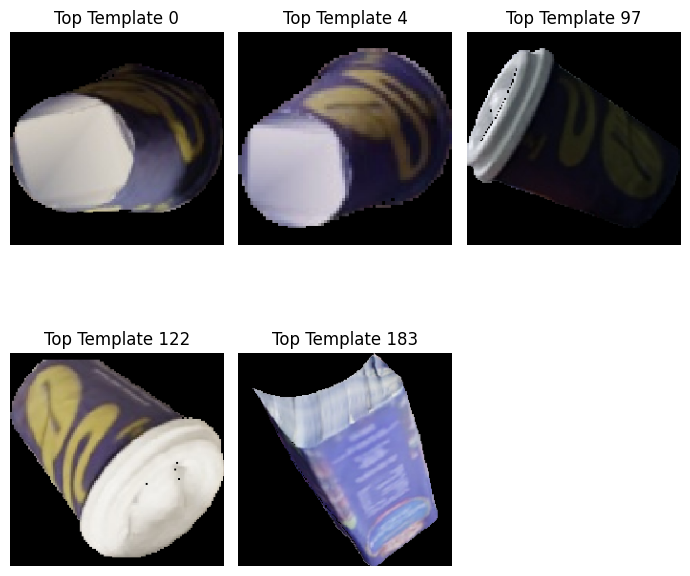

Top 5 scores: [0.596, 0.539, 0.492, 0.474, 0.435]
Average score: 0.507


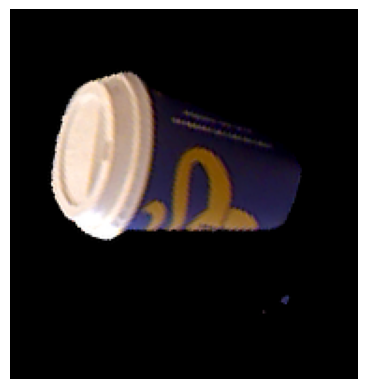

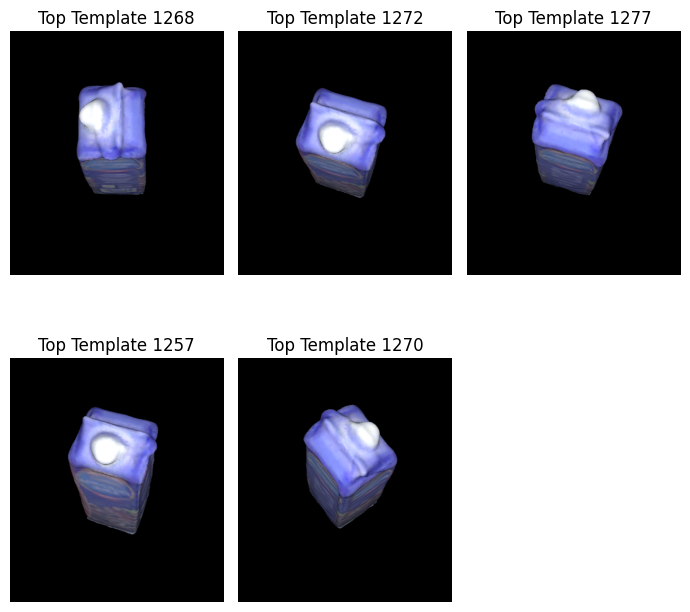

Top 5 scores: [0.841, 0.81, 0.792, 0.77, 0.754]
Average score: 0.794


tensor([[0.3181]])

In [71]:
# Rotate 120
img_120 = ndimage.rotate(img, 120, reshape=False)
full_img_120 = ndimage.rotate(img, 120, reshape=True)
# Rotate 120
rotated_120_features = cnos_crop_feature_extraction(full_img_120, dinov2_vitl14, device)
calculate_similarity(full_img_120, rotated_120_features, real_ref_features, real_templates)
calculate_similarity(full_img_120, rotated_120_features, syn_ref_features, syn_templates)
calculate_similarity(full_img_120, rotated_120_features, pyrender_ref_features, pyrender_templates)
# Calculate similarity between 2 features of normal crop and rotated_120_crop
rotated_120_scores = metric(normal_features[:, None, :], rotated_120_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_proposals*num_templates instead
rotated_120_scores


## 3.4 Occluded crop

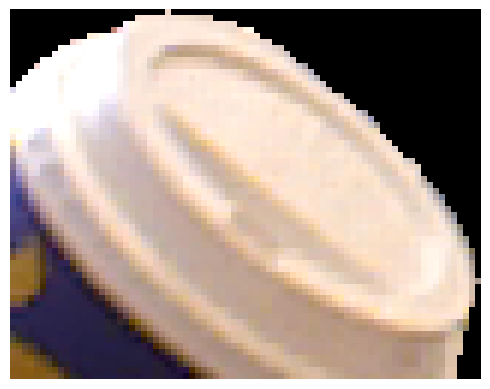

In [72]:
# occluded_crop = crop_rgb[124//2:,:157//2,:]
occluded_crop = crop_rgb[:124//2,157//2:,:]
import matplotlib.pyplot as plt
plt.imshow(occluded_crop)
plt.axis("off")
plt.show()

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


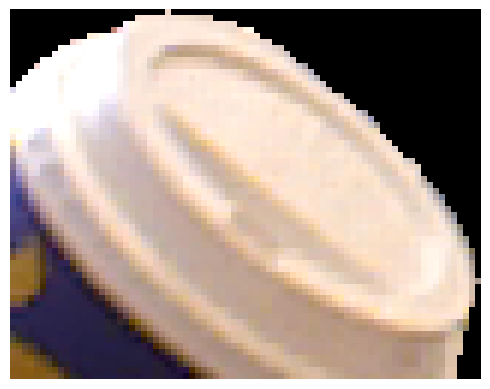

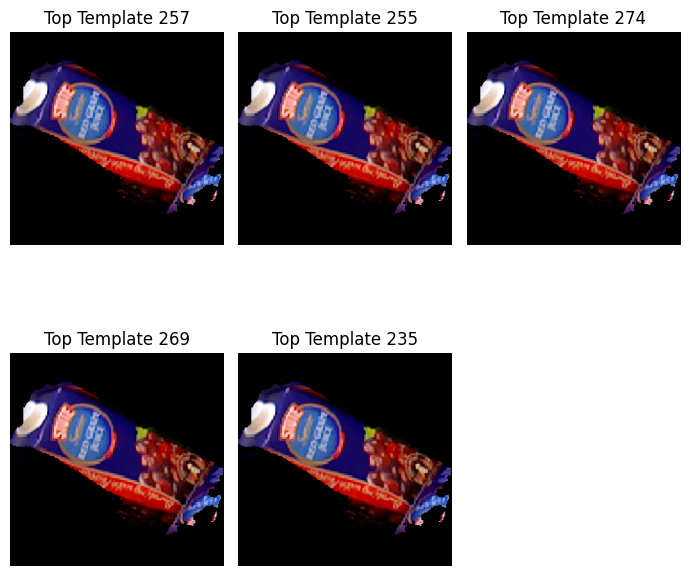

Top 5 scores: [0.92, 0.92, 0.92, 0.92, 0.92]
Average score: 0.92


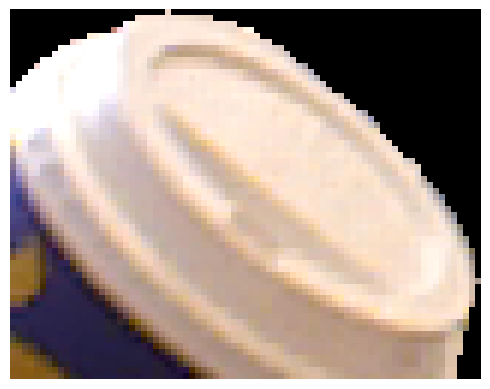

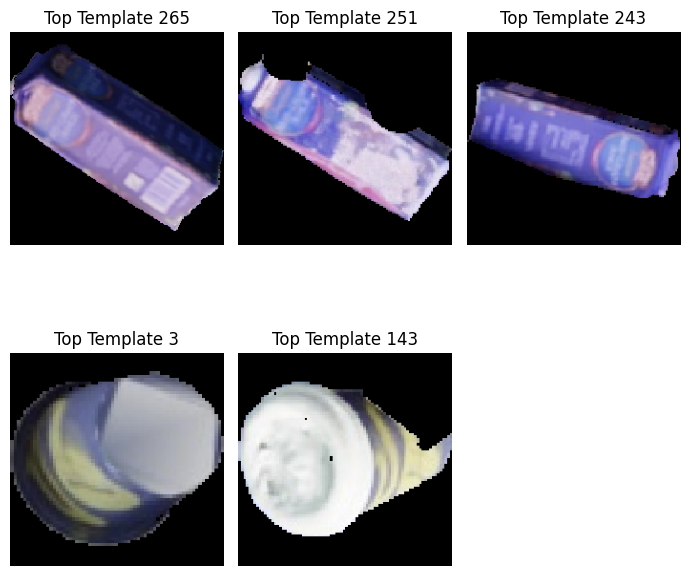

Top 5 scores: [0.889, 0.88, 0.859, 0.852, 0.849]
Average score: 0.866


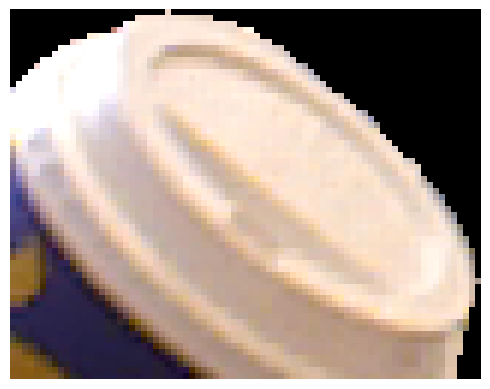

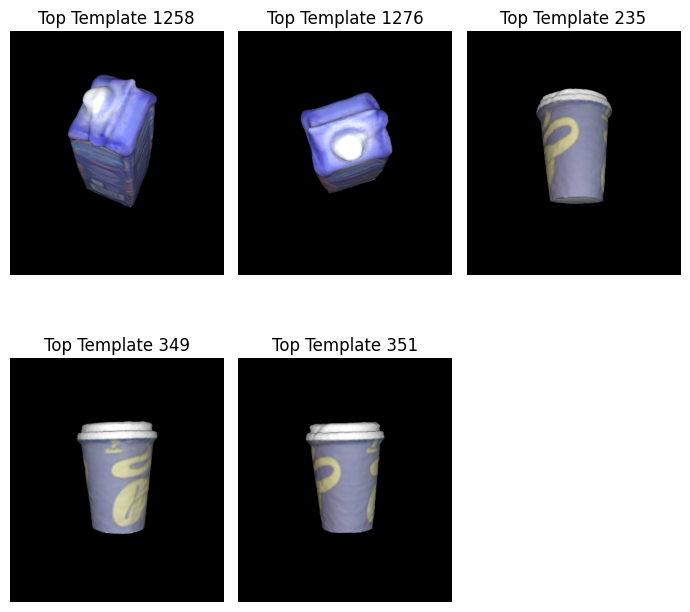

Top 5 scores: [0.678, 0.532, 0.528, 0.518, 0.518]
Average score: 0.555


tensor([[0.]])

In [73]:
occluded_features = cnos_crop_feature_extraction(occluded_crop, dinov2_vitl14, device)
# Real templates
calculate_similarity(occluded_crop, occluded_features, real_ref_features, real_templates)
calculate_similarity(occluded_crop, occluded_features, syn_ref_features, syn_templates)
calculate_similarity(occluded_crop, occluded_features, pyrender_ref_features, pyrender_templates)
# Calculate similarity between 2 features of nomrmal crop and rotated_45_crop
occluded_scores = metric(normal_features[:, None, :], occluded_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
occluded_scores

In [74]:
900,1024

(900, 1024)

## 3.5 Small crop

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


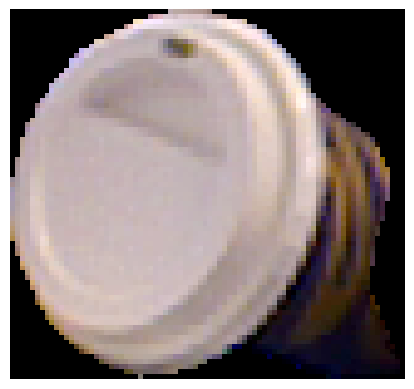

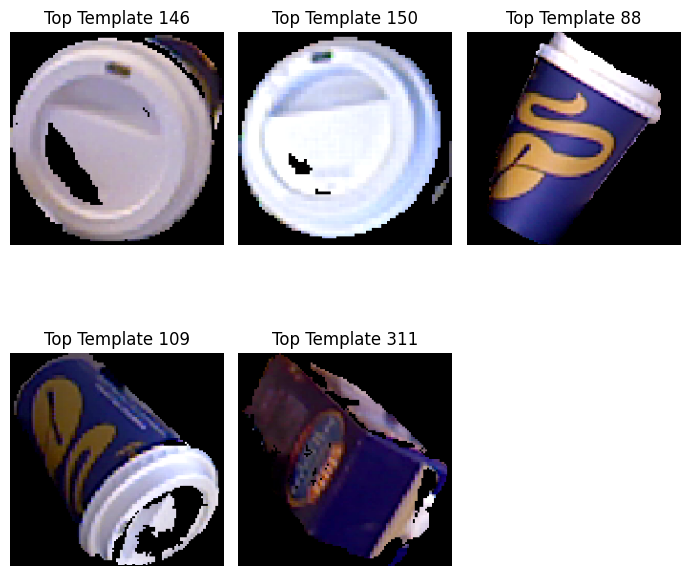

Top 5 scores: [0.924, 0.873, 0.872, 0.868, 0.867]
Average score: 0.881


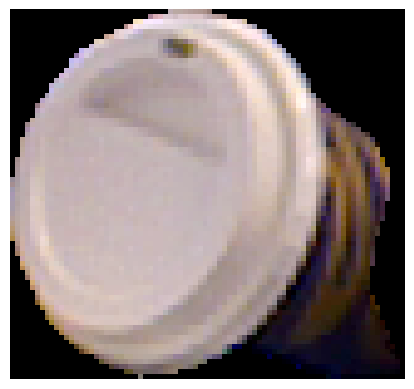

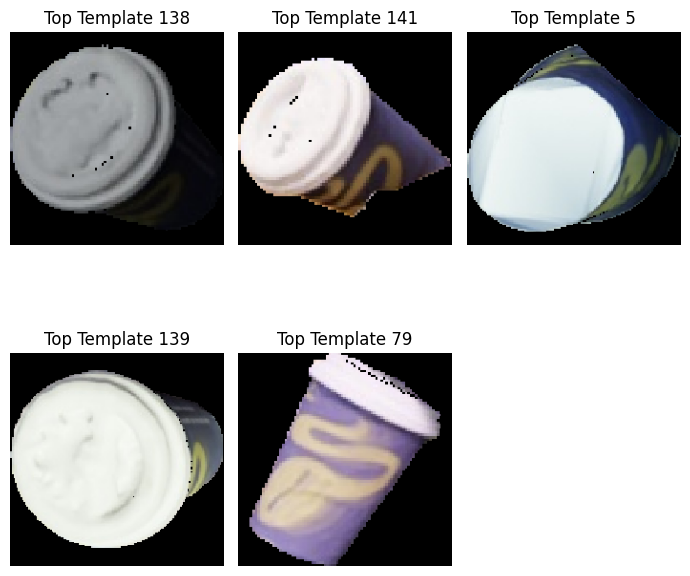

Top 5 scores: [0.936, 0.903, 0.878, 0.858, 0.849]
Average score: 0.885


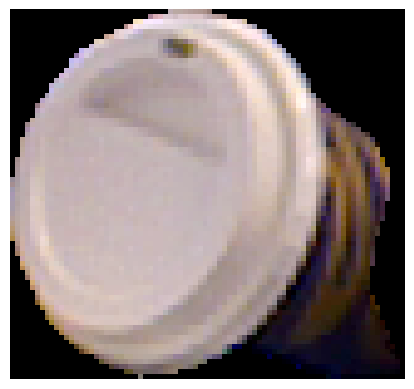

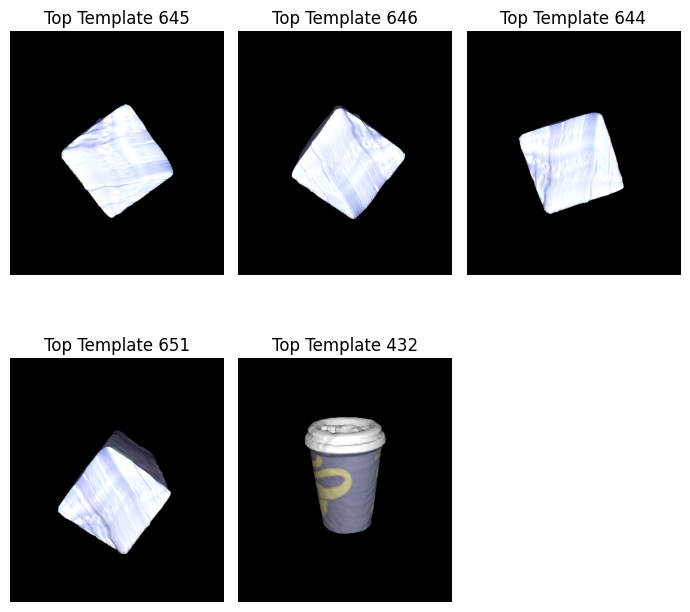

Top 5 scores: [0.846, 0.845, 0.845, 0.827, 0.827]
Average score: 0.838


In [75]:
# Small crop
small_crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop2.png").convert("RGB")) # (124, 157, 3)
# normal crop
small_features = cnos_crop_feature_extraction(small_crop_rgb, dinov2_vitl14, device)
calculate_similarity(small_crop_rgb, small_features, real_ref_features, real_templates)
calculate_similarity(small_crop_rgb, small_features, syn_ref_features, syn_templates)
calculate_similarity(small_crop_rgb, small_features, pyrender_ref_features, pyrender_templates)

In [76]:
1, 1024
162, 1024

(162, 1024)

In [77]:
30,30,1024

(30, 30, 1024)

## 3.6 Background Crop

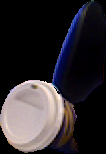

In [78]:
crop1["crop"]

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


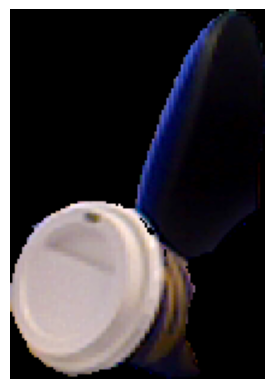

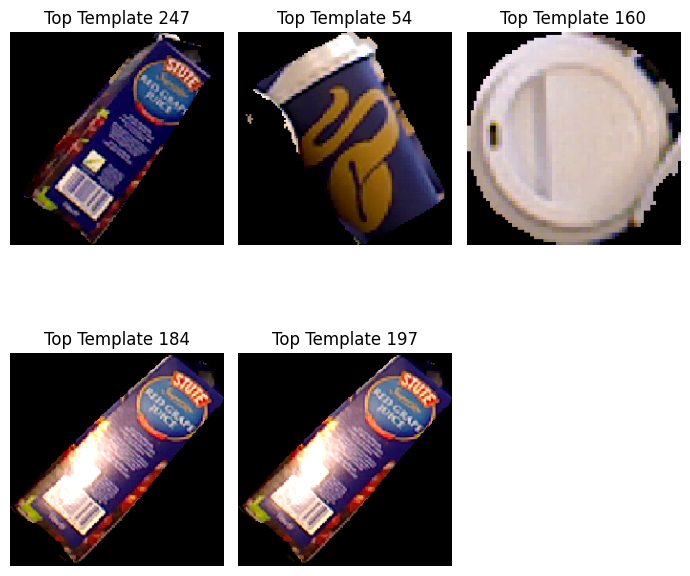

Top 5 scores: [0.785, 0.763, 0.759, 0.749, 0.749]
Average score: 0.761


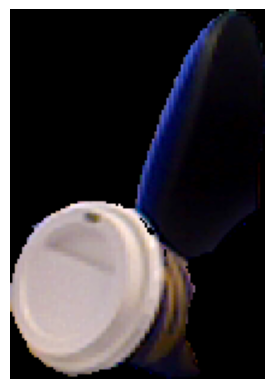

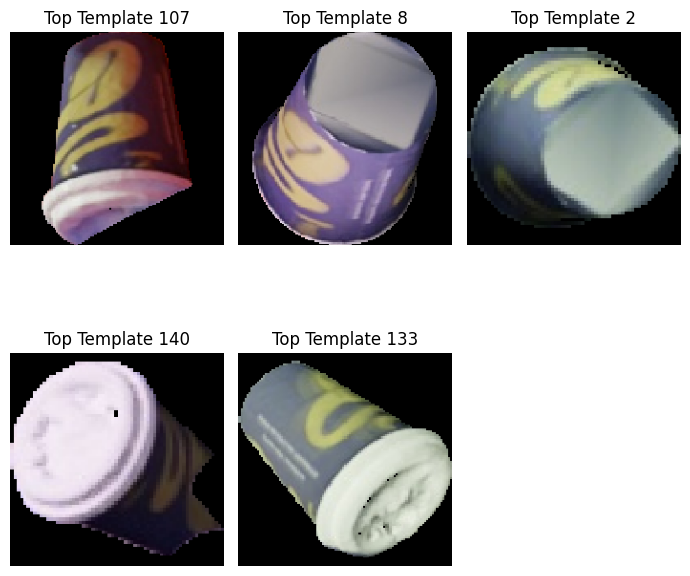

Top 5 scores: [0.788, 0.74, 0.716, 0.704, 0.697]
Average score: 0.729


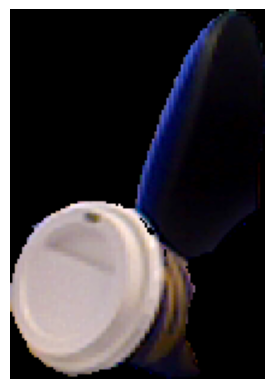

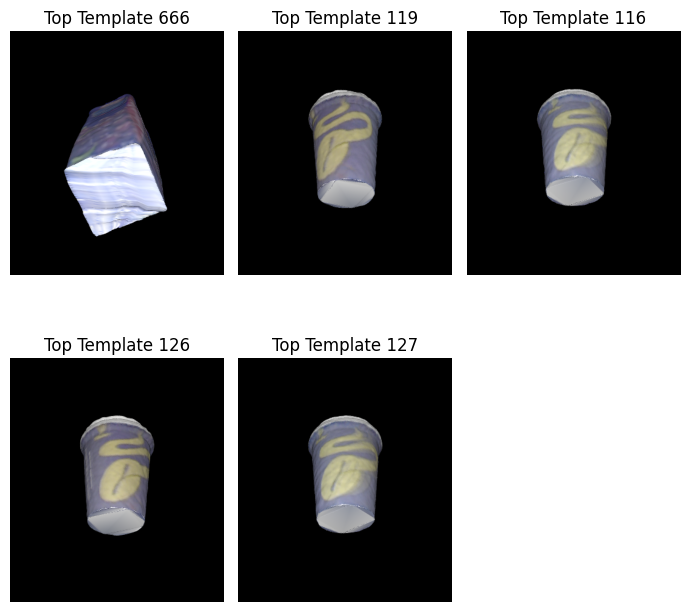

Top 5 scores: [0.829, 0.824, 0.822, 0.822, 0.82]
Average score: 0.823


In [79]:
background_crop = np.array(crop1["crop"]) # (124, 157, 3)
background_features = cnos_crop_feature_extraction(background_crop, dinov2_vitl14, device)
calculate_similarity(background_crop, background_features, real_ref_features, real_templates)
calculate_similarity(background_crop, background_features, syn_ref_features, syn_templates)
calculate_similarity(background_crop, background_features, pyrender_ref_features, pyrender_templates)

In [80]:
900*1024


921600

# 4. Final Results

In [81]:
proposals = [np.array(masked_image) for i, masked_image in enumerate(masked_images)]
proposals_features = torch.cat([cnos_crop_feature_extraction(proposal, dinov2_vitl14, device) for proposal in proposals], dim = 0)

scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])
scaled_padded_

In [82]:
proposals_features.shape

torch.Size([151, 2700])

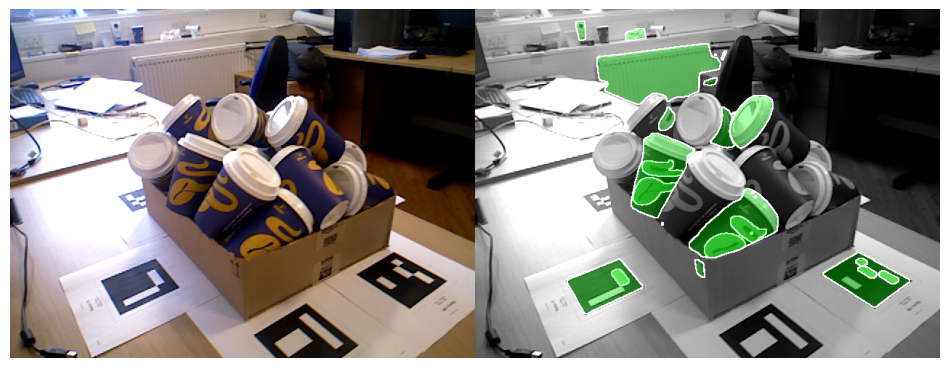

In [83]:
from src.model.custom_cnos import modified_run_inference

rgb_path = "cnos_analysis/crop_proposals/000001.png"
template_dir = "foundpose_analysis/icbin/templates/test_images_templates/obj_000001_original"
modified_run_inference(template_dir, rgb_path, detections, real_ref_features, proposals_features)# , num_max_dets=15)

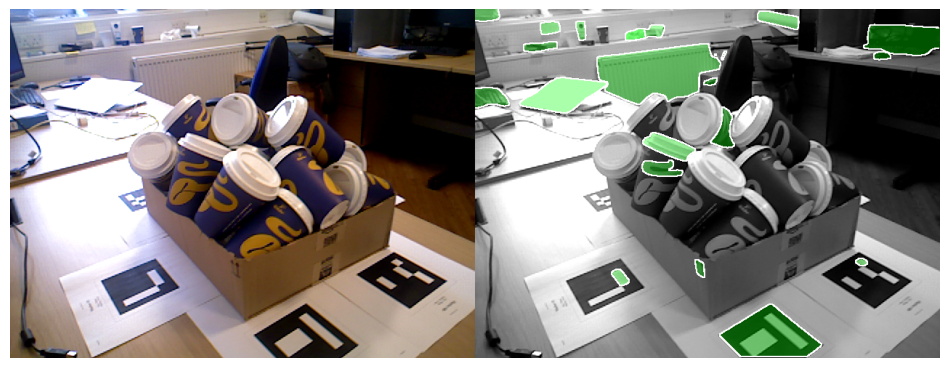

In [84]:
syn_template_dir = "foundpose_analysis/icbin/templates/train_pbr_images_templates/obj_000001_original"
modified_run_inference(syn_template_dir, rgb_path, detections, syn_ref_features, proposals_features)

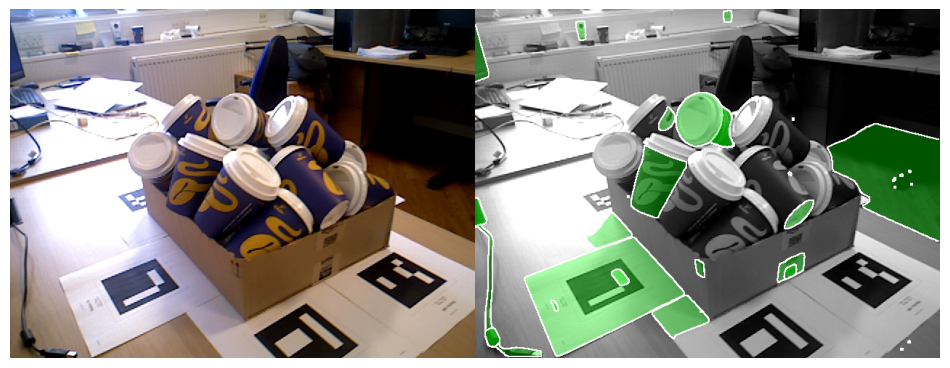

In [85]:
pyrender_template_dir = "datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_000001"
modified_run_inference(pyrender_template_dir, rgb_path, detections, pyrender_ref_features, proposals_features)